In [6]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify Paths

In [11]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# Set number of classes and input length for movement tracking

In [12]:
NUM_CLASSES = 4
TIME_STEPS = 16 # the number of input data for the model
DIMENSION = 2 # x, y locations

# Read Dataset

In [13]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(array([0, 1, 2, 3]), array([1481, 1234, 1279, 1302], dtype=int64))


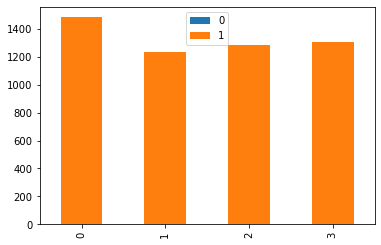

In [14]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

# Tuning Model

In [41]:
lstm = True
model = None

if lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])


In [16]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 16, 2)             0         
                                                                 
 dropout (Dropout)           (None, 16, 2)             0         
                                                                 
 lstm (LSTM)                 (None, 16)                1216      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,430
Trainable params: 1,430
Non-trainabl

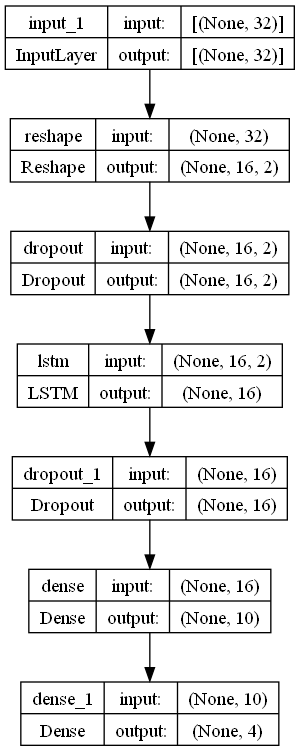

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [28]:
# compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

In [21]:
# Load saved model
model = tf.keras.models.load_model(model_save_path)

In [22]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 482ms/step
[9.7568351e-01 8.8446646e-04 4.3928078e-05 2.3388086e-02]
0


# Confusion matrix

42/42 [==============================] - 0s 2ms/step


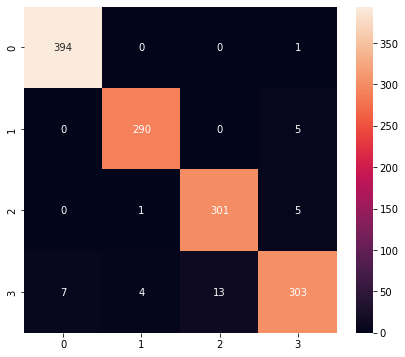

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       395
           1       0.98      0.98      0.98       295
           2       0.96      0.98      0.97       307
           3       0.96      0.93      0.95       327

    accuracy                           0.97      1324
   macro avg       0.97      0.97      0.97      1324
weighted avg       0.97      0.97      0.97      1324



In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [43]:
# save inference model
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.save(model_save_path, include_optimizer=False)
print("model saved")
model = tf.keras.models.load_model(model_save_path)
print("model loaded")


model saved


model loaded


In [44]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [47]:
# Quantise model
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\wendy\AppData\Local\Temp\tmp6yfonuo_\assets


INFO:tensorflow:Assets written to: C:\Users\wendy\AppData\Local\Temp\tmp6yfonuo_\assets


13232

# Inference test

In [48]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [49]:
# Get I/O tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_5:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [50]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [55]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 999 µs


In [52]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.24991019 0.25013193 0.25011408 0.24984375]
1
